In [ ]:
from random import random
from abc import ABC, abstractmethod
from enum import Enum
import numpy as np

class Strategy(Enum):
    ALWAYS_HELP = 1
    TIT_FOR_TAT = 2
    ALWAYS_SABOTAGE = 3

class Action(Enum):
    HELP = 1
    SABOTAGE = 2

class State(Enum):
    ELIMINATION = 1
    SAFE = 2
    DEBUT = 3

class ContestantType(Enum):
    PURE_STRATEGY = 1
    MIXED_STRATEGY = 2

class TransitionTracker:
    def __init__(self):
        self.transitions = {
            "E_E" : 0,
            "E_S" : 0,
            "E_D" : 0,
            "S_E" : 0,
            "S_S" : 0,
            "S_D" : 0,
            "D_E" : 0,
            "D_S" : 0,
            "D_D" : 0
        }
        self.eliminations = {
            "first round" : 0,
            "second round" : 0,
            "third round" : 0
        }

    def update_tracker(self, previous_state: State, current_state: State):
        if previous_state == State.ELIMINATION:
            if current_state == State.ELIMINATION:
                transition = "E_E"
            elif current_state == State.SAFE:
                transition = "E_S"
            elif current_state == State.DEBUT:
                transition = "E_D"
        elif previous_state == State.SAFE:
            if current_state == State.ELIMINATION:
                transition = "S_E"
            elif current_state == State.SAFE:
                transition = "S_S"
            elif current_state == State.DEBUT:
                transition = "S_D"
        elif previous_state == State.DEBUT:
            if current_state == State.ELIMINATION:
                transition = "D_E"
            elif current_state == State.SAFE:
                transition = "D_S"
            elif current_state == State.DEBUT:
                transition = "D_D"
        else:
            return

        self.transitions[transition] += 1

    def update_elimination_tracker(self, round: int):
        if round == 0:
            self.eliminations["first round"] += 1
        elif round == 1:
            self.eliminations["second round"] += 1
        elif round == 2:
            self.eliminations["third round"] += 1

    def get_from_elim_transition_count(self):
        return self.transitions["E_E"] + self.transitions["E_S"] + self.transitions["E_D"]
    
    def get_from_safe_transition_count(self):
        return self.transitions["S_E"] + self.transitions["S_S"] + self.transitions["S_D"]
    
    def get_from_debut_transition_count(self):
        return self.transitions["D_E"] + self.transitions["D_S"] + self.transitions["D_D"]

class InitialState:
    def __init__(self):
        self.elimination = 0
        self.safe = 0
        self.debut = 0

    def increment_elimination(self):
        self.elimination += 1

    def increment_safe(self):
        self.safe += 1

    def increment_debut(self):
        self.debut += 1

    def get_initial_state_probabilities(self):
        total = self.elimination + self.safe + self.debut
        
        return np.array([self.elimination / total, self.safe / total, self.debut / total])

class Contestant(ABC):
    def __init__(self, talent_idx, id):
        self.talent = talent_idx
        self.id = id
        self.no_of_votes = 0
        self.vote_factor = None
        self.previous_action = None
        self.transition_tracker = TransitionTracker()
        self.previous_state = None
        self.current_state = None
        self.transition_matrix = None
        self.initial_state = InitialState()

    def simulate_voting(self, no_of_voters = 10000):
        # self.restart_votes()
        self.no_of_votes = np.random.binomial(no_of_voters, 0.5)

        # Apply talent factor to votes
        self.no_of_votes += round(self.no_of_votes * 0.1 * self.talent)

        # Apply vote factor to votes
        self.no_of_votes = round(self.no_of_votes * self.vote_factor)

    def set_vote_factor(self, vote_factor):
        self.vote_factor = vote_factor

    def restart_votes(self):
        self.no_of_votes = 0

    def move_state(self):
        self.previous_state = self.current_state

    def update_state(self, new_state: State):
        self.current_state = new_state
        self.transition_tracker.update_tracker(self.previous_state, self.current_state)    

    def update_elimination_count(self, round: int):
        self.transition_tracker.update_elimination_tracker(round)

    def restart(self):
        self.restart_votes()
        self.vote_factor = None
        self.previous_action = None
        self.previous_state = None
        self.current_state = None

    def create_transition_matrix(self):
        self.transition_matrix = TransitionMatrix(self)
        

class PureStrategyContestant(Contestant):
    def __init__(self, talent_idx, id):
        super().__init__(talent_idx, id)

        self.strategy = self.initialise_strategy()

    def initialise_strategy(self):
        if self.talent < 0.5:
            strategy = Strategy.ALWAYS_SABOTAGE
        elif 0.5 <= self.talent < 0.8:
            strategy = Strategy.TIT_FOR_TAT
        else:
            strategy = Strategy.ALWAYS_HELP

        return strategy

class MixedStrategyContestant(Contestant):
    def __init__(self, talent_idx, id):
        super().__init__(talent_idx, id)
    
class ContestantPool:
    def __init__(self, talent_list, type: ContestantType):
        self.type = type
        self.active_contestants = []
        self.create_contestants(talent_list, type)
        self.eliminated = []

    def create_contestants(self, talent_list: list, type: ContestantType):
        if type == ContestantType.PURE_STRATEGY:
            for i in range(len(talent_list)):
                self.active_contestants.append(PureStrategyContestant(talent_list[i], i))
        elif type == ContestantType.MIXED_STRATEGY:
            for i in range(len(talent_list)):
                self.active_contestants.append(MixedStrategyContestant(talent_list[i], i))
        
    def get_active_contestants(self):
        return self.active_contestants
    
    def remove_contestants(self, round: int):
        # Eliminate all contestants who are not on or above the safe zone (i.e. in the elimination state)
        while True:
            if self.active_contestants[-1].current_state == State.ELIMINATION:
                eliminated_contestant = self.active_contestants.pop()
                eliminated_contestant.update_elimination_count(round)
                self.eliminated.append(eliminated_contestant)
            else:
                break

    def shuffle_active_contestants(self):
        np.random.shuffle(self.active_contestants)

    def sort_active_contestants(self):
        self.active_contestants.sort(key=lambda x: x.no_of_votes, reverse=True)

    def restart_contestants(self):
        self.active_contestants += self.eliminated
        self.eliminated.clear()

        for contestant in self.active_contestants:
            contestant.restart()
            
class BiMatrix:
    def __init__(self, bi_matrix):
        self.bi_matrix = bi_matrix
        self.row_help_prob = 1/4
        self.column_help_prob = 1/2
    
    def perform_interaction(self, row_player: Contestant, column_player: Contestant, player_type: ContestantType):
        if player_type == ContestantType.PURE_STRATEGY:    
            row_action = self.pure_strategy_interaction(row_player, column_player)
            column_action = self.pure_strategy_interaction(column_player, row_player)
            self.apply_outcome(row_player, row_action, column_player, column_action)
        elif player_type == ContestantType.MIXED_STRATEGY:
            row_action = self.mixed_strategy_interaction(row_player, determine_row_first=True)
            column_action = self.mixed_strategy_interaction(column_player, determine_row_first=False)
            self.apply_outcome(row_player, row_action, column_player, column_action)
            
    def pure_strategy_interaction(self, acting_player: PureStrategyContestant, opponent: PureStrategyContestant):
        player_strategy = acting_player.strategy

        # Determine action
        if player_strategy == Strategy.TIT_FOR_TAT:
            if opponent.previous_action is None:
                action = Action.HELP
            else:
                action = opponent.previous_action
        elif player_strategy == Strategy.ALWAYS_HELP:
            action = Action.HELP
        elif player_strategy == Strategy.ALWAYS_SABOTAGE:
            action = Action.SABOTAGE
            
        acting_player.previous_action = action

        return action
    
    def mixed_strategy_interaction(self, acting_player: MixedStrategyContestant, determine_row_first: bool):
        # Determine which action to play
        if determine_row_first:
            action = Action.HELP if random() < self.row_help_prob else Action.SABOTAGE
        else:
            action = Action.HELP if random() < self.column_help_prob else Action.SABOTAGE

        return action
    
    def apply_outcome(self, row_player: Contestant, row_input: Action, column_player: Contestant, column_input: Action):
        if row_input == Action.HELP:
            row = self.bi_matrix[0]
        elif row_input == Action.SABOTAGE:
            row = self.bi_matrix[1]

        if column_input == Action.HELP:
            payoff_tuple = row[0]
        elif column_input == Action.SABOTAGE:
            payoff_tuple = row[1]

        row_player.set_vote_factor(payoff_tuple[0])
        column_player.set_vote_factor(payoff_tuple[1])

        
class Season:
    def __init__(self, contestant_pool: ContestantPool):
        self.contestant_pool = contestant_pool
        self.contestants = self.contestant_pool.get_active_contestants()
        self.no_of_voters = 10000
        self.elimination_episodes=[3, 6, 10]
        self.safe_zone=[16, 10, 5]
        self.bi_matrix = BiMatrix([
            [(1.05, 1.18), (0.85, 1.15)],
            [(1.1, 0.89), (0.8, 0.9)]
        ])
        self.debut_size = 5

    def simulate_interactions(self):
        self.contestant_pool.shuffle_active_contestants()

        # Group contestants in pairs
        groups = []
        i = 0
        while i < len(self.contestants):
            groups.append([self.contestants[i], self.contestants[i + 1]])
            i += 2
        
        # Determine vote factor from interaction
        for group in groups:
            contestant_1 = group[0]
            contestant_2 = group[1]

            # Determine who is more talented (becomes the row player)
            contestant_type = self.contestant_pool.type
            if contestant_1.talent > contestant_2.talent:
                self.bi_matrix.perform_interaction(contestant_1, contestant_2, contestant_type)
            else:
                self.bi_matrix.perform_interaction(contestant_2, contestant_1, contestant_type)

    def simulate_voting(self):
        for contestant in self.contestants:
            contestant.simulate_voting(self.no_of_voters)

    def update_transition_tracker(self, episode):
        # Get elimination round index
        elim_idx = 0
        while episode > self.elimination_episodes[elim_idx]:
            elim_idx += 1
            if episode <= self.elimination_episodes[elim_idx]:
                break

        # Update transition states
        safe_threshold = self.safe_zone[elim_idx]

        if episode != 0:
            for contestant in self.contestants:
                contestant.move_state()

        for contestant in self.contestants[0:self.debut_size]:
            contestant.update_state(State.DEBUT)
            if episode == 0:
                contestant.initial_state.increment_debut()
        for contestant in self.contestants[self.debut_size:safe_threshold]:
            contestant.update_state(State.SAFE)
            if episode == 0:
                contestant.initial_state.increment_safe()
        for contestant in self.contestants[safe_threshold:]:
            contestant.update_state(State.ELIMINATION)    
            if episode == 0:
                contestant.initial_state.increment_elimination()         

    def simulate_season(self, episodes=10):
        for episode in range(episodes):
            # Group contestants in pairs and determine voting factor from interaction
            self.simulate_interactions()
            
            # Simulate voting for each contestant
            self.simulate_voting()
            self.contestant_pool.sort_active_contestants()

            # Update contestants' transition tracker based on their ranking in the show
            self.update_transition_tracker(episode)

            # Eliminate contestants if it's an elimination episode
            if episode + 1 in self.elimination_episodes:           
                elim_round = self.elimination_episodes.index(episode + 1)
                self.contestant_pool.remove_contestants(elim_round)

class TransitionMatrix:
    def __init__(self, contestant: Contestant):
        self.contestant = contestant
        self.matrix = None
        self.create_transition_matrix(contestant)

    def create_transition_matrix(self, contestant):
        # Get total counts for each starting state transitions
        total_elim = contestant.transition_tracker.get_from_elim_transition_count()
        total_safe = contestant.transition_tracker.get_from_safe_transition_count()
        total_debut = contestant.transition_tracker.get_from_debut_transition_count()

        elim_row = []
        safe_row = []
        debut_row = []

        # Calculate the transition probabilities
        idx = 0
        for val in contestant.transition_tracker.transitions.values():
            if idx < 3:
                elim_row.append(val / total_elim)
            elif idx < 6:
                safe_row.append(val / total_safe)
            else:
                debut_row.append(val / total_debut)
            idx += 1
        
        self.matrix = np.array([elim_row, safe_row, debut_row])

    def raise_power(self, power: int):
        if self.matrix is None:
            raise ValueError("Transition matrix has not been created yet.")
        
        matrix = np.linalg.matrix_power(self.matrix, power)

        return matrix

In [ ]:
# Define talent distributions
uniform_distribution_talents = [
    0.03, 0.07, 0.11, 0.13, 0.16, 0.18, 0.21, 0.23, 0.26, 0.29,
    0.31, 0.34, 0.36, 0.39, 0.41, 0.44, 0.46, 0.49, 0.53, 0.56,
    0.59, 0.62, 0.65, 0.68, 0.71, 0.74, 0.78, 0.82, 0.89, 0.95
]
normal_distribution_talents = [
    0.12, 0.18, 0.22, 0.27, 0.31, 0.34, 0.37, 0.39, 0.41, 0.43,
    0.45, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.55, 0.57,
    0.59, 0.61, 0.63, 0.66, 0.69, 0.73, 0.77, 0.82, 0.88, 0.94
]
many_high_talents = [
    0.35, 0.42, 0.55, 0.62, 0.68, 0.71, 0.72, 0.73, 0.74, 0.75,
    0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85,
    0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.94, 0.97, 0.99
]

def simulate_many_seasons(talent_list, contestant_strat, no_of_seasons=1000):
    # Simulate 1000 seasons
    contestant_pool = ContestantPool(talent_list, contestant_strat)

    for _ in range(1000):
        season = Season(contestant_pool)
        season.simulate_season()
        contestant_pool.restart_contestants()
    print("finish 1000 seasons")

    # Create transition matrices for every contestant
    contestant_pool.active_contestants.sort(key=lambda x: x.id)
    contestants = contestant_pool.active_contestants
    for player in contestants:
        player.create_transition_matrix()
    
    return contestant_pool

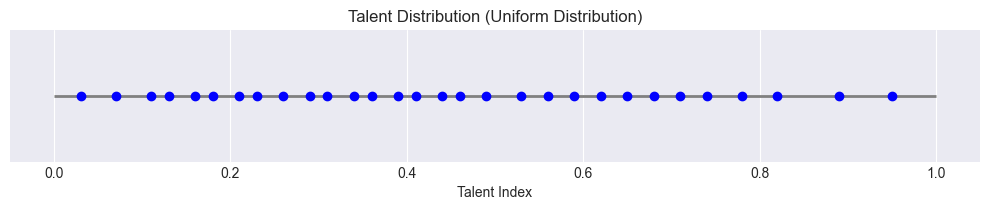

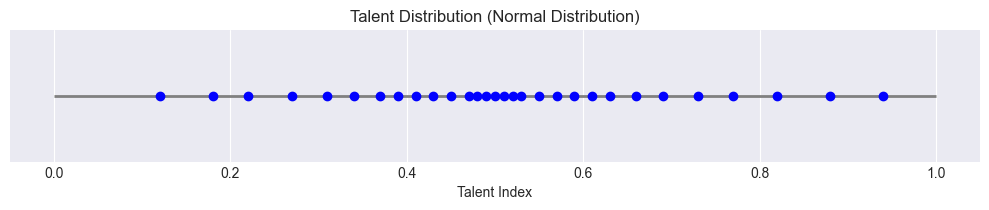

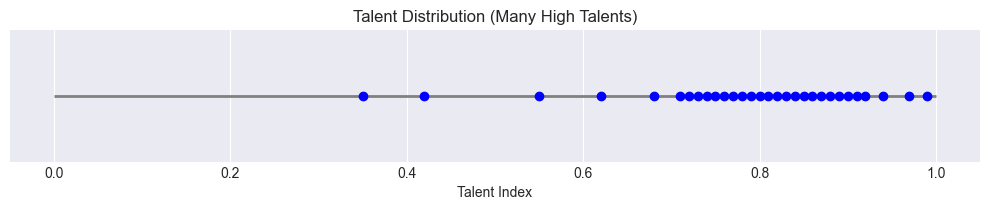

In [158]:
import matplotlib.pyplot as plt

def plot_talent_distributions(talent_distribution):
    plt.figure(figsize=(10, 2))
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.hlines(1, 0, 1, colors='gray', linewidth=2)
    plt.plot(talent_distribution, [1]*len(talent_distribution), 'o', color='b')
    plt.xlabel('Talent Index')
    plt.yticks([])
    plt.ylim(0.95, 1.05)
    plt.tight_layout()

    if talent_distribution == uniform_distribution_talents:
        title = 'Uniform Distribution'
    elif talent_distribution == normal_distribution_talents:
        title = 'Normal Distribution'
    elif talent_distribution == many_high_talents:
        title = 'Many High Talents'
    plt.title(f'Talent Distribution ({title})')
    plt.show()

plot_talent_distributions(uniform_distribution_talents)
plot_talent_distributions(normal_distribution_talents)
plot_talent_distributions(many_high_talents)

finish 1000 seasons
finish 1000 seasons
finish 1000 seasons


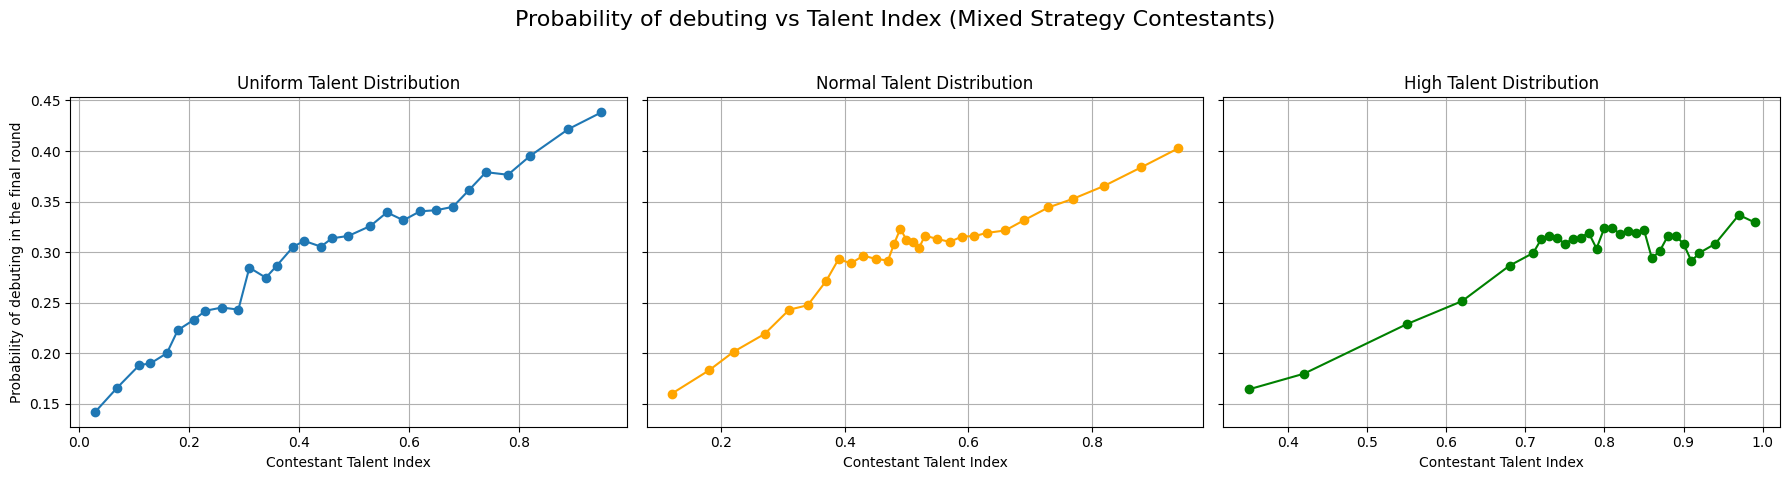

finish 1000 seasons
finish 1000 seasons
finish 1000 seasons


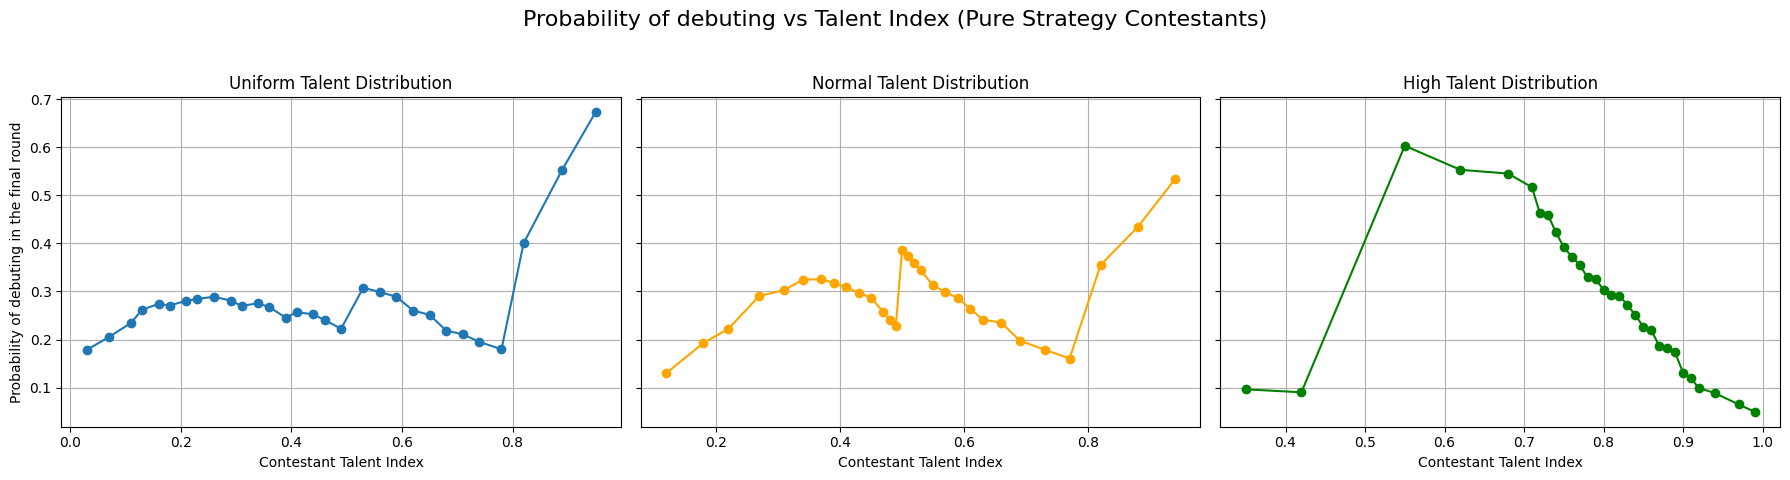

In [ ]:
def plot_debut_chances(contestant_strategy):
    # Simulate for the 3 different talent distributions
    uniform_contestants = simulate_many_seasons(uniform_distribution_talents, contestant_strategy)
    normal_contestants = simulate_many_seasons(normal_distribution_talents, contestant_strategy)
    high_contestants = simulate_many_seasons(many_high_talents, contestant_strategy)

    # Calculate debut probabilities for different contestant pools
    uniform_debut_prob = []
    normal_debut_prob = []
    high_debut_prob = []

    contestant_distribution_types = [uniform_contestants, normal_contestants, high_contestants]
    for pool in contestant_distribution_types:
        for contestant in pool.active_contestants:
            transition_matrix = contestant.transition_matrix.raise_power(9)
            state_probabilities = np.dot(contestant.initial_state.get_initial_state_probabilities(), transition_matrix)

            if pool == uniform_contestants:
                uniform_debut_prob.append(state_probabilities[2])
            elif pool == normal_contestants:
                normal_debut_prob.append(state_probabilities[2])
            elif pool == high_contestants:
                high_debut_prob.append(state_probabilities[2])

    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Uniform
    axs[0].plot(uniform_distribution_talents, uniform_debut_prob, 'o-')
    axs[0].set_title("Uniform Talent Distribution")
    axs[0].set_xlabel("Contestant Talent Index")
    axs[0].set_ylabel("Probability of debuting in the final round")
    axs[0].grid(True)

    # Normal
    axs[1].plot(normal_distribution_talents, normal_debut_prob, 'o-', color='orange')
    axs[1].set_title("Normal Talent Distribution")
    axs[1].set_xlabel("Contestant Talent Index")
    axs[1].grid(True)

    # Many High Talents
    axs[2].plot(many_high_talents, high_debut_prob, 'o-', color='green')
    axs[2].set_title("High Talent Distribution")
    axs[2].set_xlabel("Contestant Talent Index")
    axs[2].grid(True)

    if contestant_strategy == ContestantType.MIXED_STRATEGY:
        title = "Mixed"
    else:
        title = "Pure"
    fig.suptitle(f"Probability of debuting vs Talent Index ({title} Strategy Contestants)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_debut_chances(ContestantType.MIXED_STRATEGY)
plot_debut_chances(ContestantType.PURE_STRATEGY)